Preprocessing
* [x] Use raw (without replacing words)
* [x] Strip HTML (not perfectly parsed)
* [x] Combine without-accents with with-accents using FeatureUnion
* [x] Combine embedding with TFIDF

Basic Config

In [1]:
!pip install unidecode bs4 emoji pyvi gensim eli5

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string

In [3]:
data_path = 'drive/My Drive/hiip/data'
train_path = f'{data_path}/train.csv'
test_path = f'{data_path}/test.csv'

In [4]:
train = pd.read_csv(train_path, header=0)
test = pd.read_csv(test_path, header=0)

In [6]:
train.head(10)

,id,text,class
0,14feb4e5,"Đến quán 2 lần thôi , rất là thích !\nQuán tuy...",1
1,9c6f6036,Đến quán vào tối chủ nhật . Có band hát . Khá ...,0
2,0f462cfe,Phục vụ lâu quá mặc dù khách rất vắng .\nĐợi g...,0
3,741fd21b,"Ko gian bé tí , quán chật chội , đông người nê...",0
4,5cd6dbbc,"Khi mình order , đặt bánh thì nhận được sự tiế...",1
5,a9b0679b,An ở đây lần thứ n mà giờ mới review . Quán lú...,0
6,d0919c4a,Quán rất đẹp . Nhạc rất hay . Rất art ! ! Bước...,1
7,a7dd3e51,Gemini thì nhạc bao hay òy : 3 Dj đánh là lên ...,1
8,4dc3df78,Mình và bạn mình vào đây ngày 8/3 . Mình thấy ...,0
9,62672cb1,"trưa ghé đây ăn , , tô bò gân , gân thì không ...",0


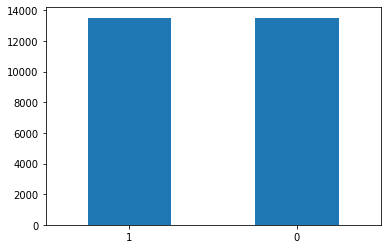

In [7]:
train['class'].value_counts().plot(kind='bar', rot=0)

In [8]:
# Is there any missing values?
train.isna().sum()

id       0
text     0
class    0
dtype: int64

## Feature engineering

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
stopwords = set(open(f'{data_path}/stopwords.txt', 'r').read().splitlines())
list(stopwords)[:5]

['phắt', 'là là', 'cu cậu', 'về tay', 'chẳng phải']

In [9]:
replaces = {
       'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        "👹": "negative", "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
        "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':' positive ',
        '👎': ' negative ', '😣': ' negative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' positive ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' negative ', '😢': ' negative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' negative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' negative ', '😭': ' negative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' negative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' negative ', '😀': ' positive ', ':((': ' negative ', '😡': ' negative ', '😠': ' negative ',
        '😒': ' negative ', '🙂': ' positive ', '😏': ' negative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' negative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' negative ', '😓': ' negative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ', '=)))': ' positive ',
        ': ) ) )': 'positive', '= ) ) )': 'positive', '= ) ) ) )': 'positive',
        '💓': ' positive ', '😐': ' negative ', ':3': ' positive ', '😫': ' negative ', '😥': ' negative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' negative ', '😑': ' negative ', '🔥': ' negative ', '🙏': ' negative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' negative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' positive ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' negative ',  '💀': ' negative ',
        '😔': ' negative ', '😧': ' negative ', '😩': ' negative ', '😰': ' negative ', '😳': ' negative ',
        '😵': ' negative ', '😶': ' negative ', '🙁': ' negative ',
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' negative ',' cc ': ' negative ','cute': u' dễ thương ','huhu': ' negative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ', 'trog': u' trong ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
}

In [10]:
with open('drive/My Drive/hiip/utils/neg.txt', 'r') as f:
  neg = f.readlines()
neg_words = set([w.replace('\n', '') for w in neg])

with open('drive/My Drive/hiip/utils/pos.txt', 'r') as f:
  pos = f.readlines()
pos_words = set([w.replace('\n', '') for w in pos])

with open('drive/My Drive/hiip/utils/not.txt', 'r') as f:
  not_ = f.readlines()
not_words = set([w.replace('\n', '') for w in not_])

not_words

{'chưa', 'chẳng', 'không', 'kém', 'not', 'nỏ', 'vô', 'đéo', 'đếch'}

## Some basic preprocessing

In [11]:
import re
import unidecode

from bs4 import BeautifulSoup

def preprocess(data, training=False):
  def remove_punctuations(text):
    return text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

  def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word not in stopwords])

  def remove_repeated_chars(text):
    # Remove cases like "hiiiii"
    return re.sub(r'([A-Z])\1+', lambda w: w.group(1), text, flags=re.IGNORECASE)

  def tokenize(text):
    from pyvi import ViTokenizer
    text = ViTokenizer.tokenize(text)
    text = text.replace('_', ' ')
    return text

  def strip_redundancy(text):
    # Some redundant characters.
    text = text.replace(u'"', u' ')
    text = text.replace(u'️', u'')
    text = text.replace('🏻','')

    # Remove new lines.
    return ' '.join(text.strip().splitlines())

  def correct_spelling(text):
    for bad, good in replaces.items():
      text = text.replace(bad, good)
    return text

  def remove_numbers(text):
    return re.sub(r'\w*\d\w*', '', text)

  def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

  def remove_single_word(text):
    #return re.sub(r'\b[a-zA-Z]\b', '', text)
    return re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  
  def remove_accent(text):
    return unidecode.unidecode(text)

  def remove_double_negative(row):
    text = row['text']
    label = row['class']

    if label == 1:
      text = ' '.join([word for word in text.split() if word not in neg_words and word not in not_words])

    row['text'] = text
    return row

  def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    return text

  data = data.copy()
  
  data['text'] = (data['text']
                  .str.lower()
                  .apply(lambda text: correct_spelling(text))
                  .apply(lambda text: remove_numbers(text))
                  .apply(lambda text: remove_punctuations(text))
                  .apply(lambda text: remove_repeated_chars(text))
                  .apply(lambda text: remove_single_word(text))
                  .apply(lambda text: tokenize(text))
                  .apply(lambda text: strip_redundancy(text))
                  .apply(lambda text: strip_html(text))
                  #.apply(lambda text: remove_stopwords(text))
                  #.apply(lambda text: remove_urls(text))
  )

  if training:
    data = data.apply(lambda row: remove_double_negative(row), axis=1)
  
  return data

In [17]:
train, valid = train_test_split(train, test_size=0.2, random_state=42)

prep_train = preprocess(train)
prep_valid = preprocess(valid)
prep_test = preprocess(test)

In [24]:
list(prep_train.tail(5)['text'])

['món bột chiên ruột của mình nhỏ nhỏ sg đây rồi mười mấy năm rồi ngày đó ăn sáng sáng nào cũng ra ăn dĩa positive',
 'món ăn thì cũng ngon khg có gì đáng nói giá cả bình dân hợp túi tiền quán trong hẻm rộng rãi xe để kế bên cũng an tâm chỉ có là đặt hàng xong ngồi chờ rã cả họng anh thanh niên đẹp chai mới tàn tàn lại thông báo món này hết ròi k yêu đặt hàng món khác giùm lại khoảng thời gian dài đằng đẵng nữa chờ đợi trong tuyệt vọng tới mức hết chuyện để với nhau mới thấy có món dọn lên ăn đây lần lần nào cũng vậy',
 'cực kì ấn tượng với piza đây lúc đầu mình tưởng mua tặng áp dụng với clasical thôi ai ngờ áp dụng hết với cả seafod và deluxe phong cách khá chuyên nghiệp bộ dao nĩa sẵn trên bàn có giấy lót siêu đẹp nhân viên hỏi số lượng khách rồi lấy thêm ghế cho mình sau đó bạn ấy còn hỏi tên mình để hướng dẫn bạn mình tới sau biết chỗ mà lên lúc ăn còn gợi món nào ngon uống nước nào cho rẻ và cả chương trình khuyến mãi nhân viên có bộ đàm trao đổi với nhau nữa đây có cả chai peper

In [14]:
prep_train.to_csv(f'{data_path}/train_prep.csv', index=False)
prep_test.to_csv(f'{data_path}/test_prep.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split
# prep_train = pd.read_csv(f'{data_path}/train_prep.csv', header=0)
# prep_test = pd.read_csv(f'{data_path}/test_prep.csv', header=0)
# X_train, X_valid, y_train, y_valid = train_test_split(prep_train['text'], prep_train['class'], test_size=0.2, random_state=42)

## Baseline fitting

Fit different features on a simple Linear SVM Classifier.

### Helper functions

In [21]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
from eli5 import explain_prediction, show_prediction
from IPython.core.display import display, HTML
from sklearn.model_selection import cross_val_score

def make_pipe():
  svc = LinearSVC(C=10.0, random_state=42)
  vectorizer = TfidfVectorizer(ngram_range=(1,6), sublinear_tf=True) 
  pipe = make_pipeline(vectorizer, svc)
  return pipe

def fit_and_test_pipe(pipe, train, valid):
  # Train test split
  X_train, y_train = train['text'], train['class']
  X_valid, y_valid = valid['text'], valid['class']

  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_valid)
    
  print(classification_report(y_valid, y_pred, target_names=['0','1']))
  print(f'accuracy={accuracy_score(y_valid, y_pred)}')
  plot_confusion_matrix(pipe, X_valid, y_valid)
  plt.show()
  return pipe, y_pred

def error_analysis(train, valid, k):
  svc = LinearSVC(C=10.0, random_state=42)
  vectorizer = TfidfVectorizer(ngram_range=(1,6), sublinear_tf=True) 
  X_train = vectorizer.fit_transform(train['text'])
  svc.fit(X_train_, prep_train['class'])

  for text in valid['text'][:k]:
    display(show_prediction(svc, doc=text, vec=vectorizer, top=20))

def cross_val_pipe(pipe, cv=3):
  full_train = pd.read_csv(train_path, header=0)
  full_prep = preprocess(full_train)
  X_full, y_full = full_prep['text'], full_prep['class']
  full_pipe = make_pipe()
  cv_scores = cross_val_score(full_pipe, X_full, y_full, verbose=1, scoring='accuracy', cv=3)
  return cv_scores

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


### Word2Vec

In [17]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec, KeyedVectors

class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, size=400):
        self.size = size
        self.model_ = KeyedVectors.load_word2vec_format(f'{data_path}/baomoi.model.bin', binary=True)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words.split() if word in self.model_.vocab]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_[word]

            return np.mean(embedding, axis=0)
        else:
            return np.random.normal(0, np.sqrt(0.25), self.size)

Take a peek at pre-trained ViWord2Vec

In [ ]:
from sklearn.decomposition import PCA
# Create Word2Vec model.
gensim_word2vec_tr = GensimWord2VecVectorizer(size=400, min_count=3, sg=1, alpha=0.025, iter=50)

# PCA to reduce the dimension down to 2.
vocab = list(gensim_word2vec_tr.model_.vocab)
X_vocab = gensim_word2vec_tr.model_[vocab]
pca = PCA(n_components=2)
X_vocab_re = pca.fit_transform(X_vocab)

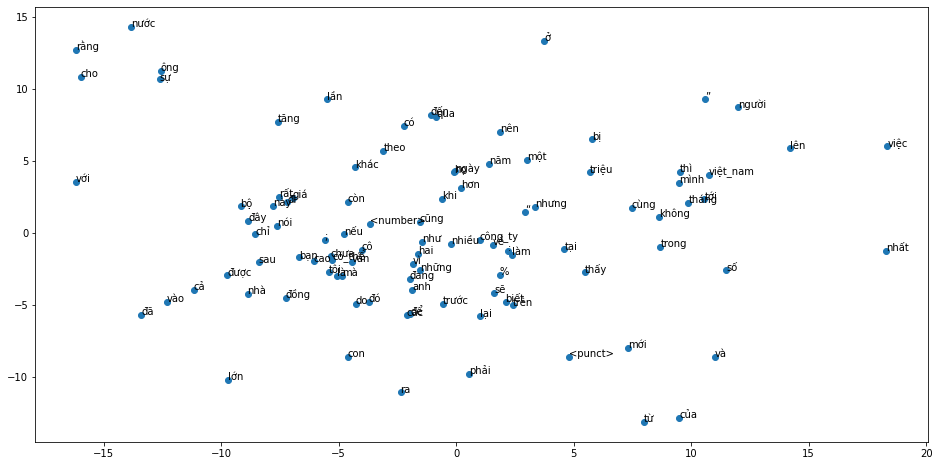

In [ ]:
# Take a peek.
indices = np.random.permutation(100)
sub_x, sub_y = X_vocab_re[indices, 0], X_vocab_re[indices, 1]
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(sub_x, sub_y)
for i in indices:
  word = vocab[i]
  ax.annotate(word, (sub_x[i], sub_y[i]))

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Word2Vec + PCA + XGBoost
gensim_word2vec_tr = GensimWord2VecVectorizer(size=400, min_count=3, sg=1, alpha=0.025, iter=50)
xgb = XGBClassifier(learning_rate=0.1, n_estimators=10, n_jobs=-1, gamma=1.0)
pca = PCA(n_components=250, random_state=42)
w2v_xgb = Pipeline([
    ('w2v', gensim_word2vec_tr), 
    ('pca', pca),
    ('xgb', xgb)
])

X_train, y_train = prep_train['text'], prep_train['class']
X_valid, y_valid = prep_valid['text'], prep_valid['class']
w2v_xgb.fit(X_train, y_train)
y_pred = w2v_xgb.predict(X_valid)
print('accuracy= %s' % accuracy_score(y_valid, y_pred))

accuracy= 0.7296296296296296


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

gensim_word2vec_tr = GensimWord2VecVectorizer(size=400)
svc = LinearSVC(C=100.0, random_state=42, max_iter=50000)
w2v_svc = Pipeline([
    ('w2v', gensim_word2vec_tr), 
    ('svc', svc)
])

X_train, y_train = prep_train['text'], prep_train['class']
X_valid, y_valid = prep_valid['text'], prep_valid['class']
w2v_svc.fit(X_train, y_train)
w2v_pred = w2v_svc.predict(X_valid)

In [31]:
print('accuracy= %s' % accuracy_score(y_valid, w2v_pred))

accuracy= 0.8422222222222222


### Without preprocessing

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      2653
           1       0.86      0.94      0.90      2747

    accuracy                           0.89      5400
   macro avg       0.90      0.89      0.89      5400
weighted avg       0.90      0.89      0.89      5400

accuracy=0.8946296296296297


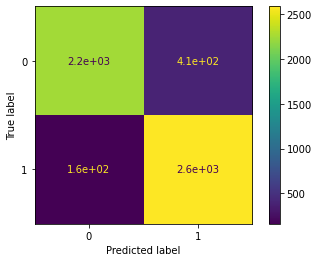

In [32]:
# Test on raw data
raw_pipe = make_pipe()
raw_pipe, raw_pred = fit_and_test_pipe(raw_pipe, train, valid)

### With preprocessing

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      2653
           1       0.87      0.95      0.91      2747

    accuracy                           0.90      5400
   macro avg       0.90      0.90      0.90      5400
weighted avg       0.90      0.90      0.90      5400

accuracy=0.9014814814814814


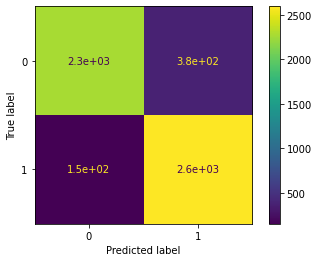

In [33]:
pipe_prep = make_pipe()
pipe_prep, y_pred = fit_and_test_pipe(pipe_prep, prep_train, prep_valid)

In [32]:
from joblib import dump, load
dump(pipe_prep, 'drive/My Drive/hiip/pipeline/tf_svm.joblib') 

['drive/My Drive/hiip/pipeline/tf_svm.joblib']

### W/o accents

              precision    recall  f1-score   support

           0       0.82      0.46      0.59      2653
           1       0.63      0.91      0.75      2747

    accuracy                           0.69      5400
   macro avg       0.73      0.68      0.67      5400
weighted avg       0.73      0.69      0.67      5400

accuracy=0.6851851851851852


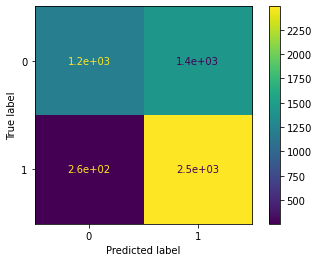

In [34]:
prep_train_wo_accents = prep_train.copy()
prep_train_wo_accents['text'] = prep_train['text'].apply(lambda text: unidecode.unidecode(text))

pipe_wo_accents = make_pipe()
pipe_wo_accents, wo_accents_pred = fit_and_test_pipe(pipe_wo_accents, prep_train_wo_accents, prep_valid)

### Union with and w/o accents

In [15]:
import scipy.sparse as sp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

class RemoveAccent(BaseEstimator, TransformerMixin):
  def _remove_accent(self, s):
      return unidecode.unidecode(s)

  def transform(self, x):
      return [self._remove_accent(text) for text in x]

  def fit(self, x, y=None):
      return self

class RemoveDoubleNegative(BaseEstimator, TransformerMixin):
    def _remove_double_negative(self, text, label):
      if label == 1:
        text = ' '.join([word for word in text.split() if word not in neg_words and word not in not_words])
      return text
    
    def transform(self, X):
      y = self.y
      return [self._remove_double_negative(text, label) for text, label in zip(X, y)]

    def fit(self, X, y=None):
      self.y = y
      return self

Various tfidf with accents + various tfidf without accents

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2653
           1       0.89      0.90      0.90      2747

    accuracy                           0.90      5400
   macro avg       0.90      0.90      0.90      5400
weighted avg       0.90      0.90      0.90      5400

accuracy=0.8951851851851852


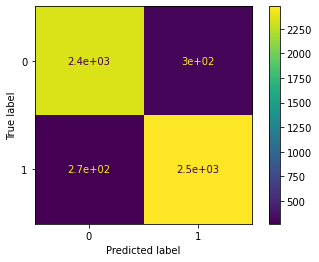

In [36]:
union_pipe = Pipeline([
  ('union', FeatureUnion([
    ('with_accent', FeatureUnion([
      ('tfidf_word', TfidfVectorizer(ngram_range=(1,6), sublinear_tf=True)),
      ('tfidf_word_char', TfidfVectorizer(ngram_range=(1,4), sublinear_tf=True, analyzer='char')),
      ('tfidf_word_char_wb', TfidfVectorizer(ngram_range=(1,4), sublinear_tf=True, analyzer='char_wb')),
    ])),
    ('wo_accent', Pipeline([
      ('remove_accent', RemoveAccent()),
      ('wo_accent_features', FeatureUnion([
        ('wo_tfidf_word', TfidfVectorizer(ngram_range=(1,6),sublinear_tf=True)),
        ('wo_tfidf_char', TfidfVectorizer(ngram_range=(1,4), analyzer='char')),
        ('wo_tfidf_char_wb', TfidfVectorizer(ngram_range=(1,4), analyzer='char_wb')),
      ])),
    ])),
  ])),
  ('base_model', LinearSVC(C=10.0, random_state=42))
])

union_pipe, massive_union_pred = fit_and_test_pipe(union_pipe, prep_train, prep_valid)

1 tfidf with accent + 1 tfidf without accent

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      2653
           1       0.87      0.94      0.91      2747

    accuracy                           0.90      5400
   macro avg       0.90      0.90      0.90      5400
weighted avg       0.90      0.90      0.90      5400

accuracy=0.9014814814814814


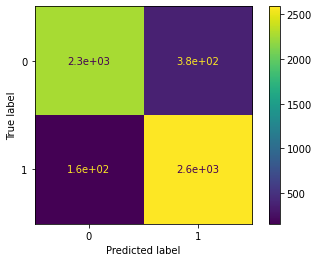

In [37]:
# With accent tfidf + without accent
union_pipe = Pipeline([
  ('union', FeatureUnion([
    ('with_accent', FeatureUnion([
      ('tfidf_word', TfidfVectorizer(ngram_range=(1,6), sublinear_tf=True)),
    ])),
    ('wo_accent', Pipeline([
      ('remove_accent', RemoveAccent()),
      ('wo_tfidf_word', TfidfVectorizer(ngram_range=(1,6),sublinear_tf=True)),
    ])),
  ])),
  ('base_model', LinearSVC(C=10.0, random_state=42))
])

union_pipe, union_pred_1 = fit_and_test_pipe(union_pipe, prep_train, prep_valid)

Embedding + with accent TFIDF + without accent TFIDF

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.95      0.82      0.88      2653
           1       0.85      0.96      0.90      2747

    accuracy                           0.89      5400
   macro avg       0.90      0.89      0.89      5400
weighted avg       0.90      0.89      0.89      5400

accuracy=0.8924074074074074


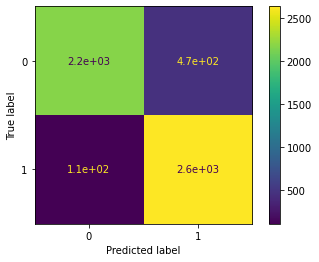

In [21]:
from sklearn.svm import LinearSVC

union_pipe_2 = Pipeline([
  ('union', FeatureUnion([
    ('tfidf_word', TfidfVectorizer(ngram_range=(1,6), sublinear_tf=True)),
    ('wo_accent', Pipeline([
      ('remove_accent', RemoveAccent()),
      ('wo_tfidf_word', TfidfVectorizer(ngram_range=(1,6),sublinear_tf=True)),
    ])),
    ('embedding', GensimWord2VecVectorizer())
  ])),
  ('svc', LinearSVC(C=100.0, random_state=42))
])

union_pipe_2, union_pred_2 = fit_and_test_pipe(union_pipe_2, prep_train, prep_valid)

With accent tfidf + without accent tfidf + without double negative tfidf

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      2653
           1       0.84      0.91      0.88      2747

    accuracy                           0.87      5400
   macro avg       0.87      0.87      0.87      5400
weighted avg       0.87      0.87      0.87      5400

accuracy=0.8694444444444445


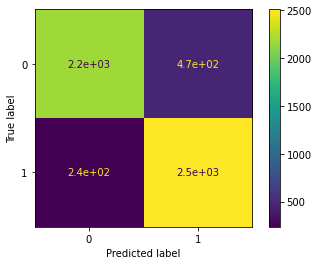

In [22]:
# With accent tfidf + without accent tfidf + without double negative tfidf

union_pipe_3 = Pipeline([
  ('union', FeatureUnion([
    ('tfidf_word', TfidfVectorizer(ngram_range=(1,6), sublinear_tf=True)),
    ('wo_accent', Pipeline([
      ('remove_accent', RemoveAccent()),
      ('wo_tfidf_word', TfidfVectorizer(ngram_range=(1,6),sublinear_tf=True)),
    ])),
    ('double_neg', Pipeline([
      ('remove_double_neg', RemoveDoubleNegative()),
      ('double_tfidf_word', TfidfVectorizer(ngram_range=(1,6), sublinear_tf=True)),
    ])),
  ])),
  ('svc', LinearSVC(C=10.0, max_iter=5000, random_state=42))
])

union_pipe_3, union_pred_3 = fit_and_test_pipe(union_pipe_3, prep_train, prep_valid)

### Dimensionality Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

dim_reduction = Pipeline([
  ('tfidf', TfidfVectorizer(ngram_range=(1,5))),
  ('svd', TruncatedSVD(n_components=500, random_state=42)),
  ('base_model', LinearSVC(C=100, random_state=42)),
])

dim_reduction_pipe, dim_reduction_pred = fit_and_test_pipe(dim_reduction, prep_train, prep_valid)

### Extra features

In [26]:
import emoji

def extract_emojis(text):
  
  return [w for w in text if w in emoji.UNICODE_EMOJI]

def get_labeled_emojis(data, label):
  labeled_df = data[data['class'] == label]
  labeled_comments = labeled_df['text'].values
  labeled_emoji = []

  for comment in labeled_comments:
    labeled_emoji += extract_emojis(comment)

  return set(labeled_emoji)

pos_emoji = get_labeled_emojis(train, 1)
neg_emoji = get_labeled_emojis(train, 0)

def count_emojis(row):
  text = row['text']
  n_pos = 0
  n_neg = 0

  for w in text.split():
    if w in pos_emoji:
      n_pos += 1
    if w in neg_emoji:
      n_neg += 1
    
  row['n_pos_emoji'] = n_pos
  row['n_neg_emoji'] = n_neg

  return row

In [27]:
train_extra = train.copy()
# Count emojis.
train_extra = train_extra.apply(count_emojis, axis=1)
train_extra = preprocess(train_extra)

# Add some static features.
train_extra['ratio_neg_pos_emoji'] = train_extra['n_pos_emoji'] / train_extra['n_neg_emoji']
train_extra['ratio_neg_pos_emoji'] = train_extra['ratio_neg_pos_emoji'].fillna(0.0).replace(np.inf, 99.0)
train_extra['diff_neg_pos_emomji'] = train_extra['n_pos_emoji'] - train_extra['n_neg_emoji']
train_extra['sum_neg_pos_emomji'] = train_extra['n_pos_emoji'] - train_extra['n_neg_emoji']

train_extra['num_words'] = train_extra['text'].apply(lambda text: len(text.split()))
train_extra['num_unique_words'] = train_extra['text'].apply(lambda text: len(set(t for t in text.split())))
train_extra['ratio_unique_words'] = train_extra['num_unique_words'] / train_extra['num_words']

In [28]:
# Splitting into train and valid subsets
train_extra, valid_extra = train_test_split(train_extra, test_size=0.2, random_state=42)
X_train_extra, y_train_extra = train_extra.loc[:, train_extra.columns != 'class'], train_extra['class']
X_valid_extra, y_valid_extra = valid_extra.loc[:, valid_extra.columns != 'class'], valid_extra['class']

In [29]:
tfidf = TfidfVectorizer(ngram_range=(1,5), max_features=10000, sublinear_tf=True)
X_train_extra_tfidf = tfidf.fit_transform(X_train_extra['text'].values)
X_valid_extra_tfidf = tfidf.transform(X_valid_extra['text'].values)

In [30]:
static_cols = ['ratio_neg_pos_emoji', 'diff_neg_pos_emomji', 'sum_neg_pos_emomji', 'num_words', 'num_unique_words', 'ratio_unique_words']
X_train_extra_static = X_train_extra[static_cols].values
X_valid_extra_static = X_valid_extra[static_cols].values

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_extra_static = scaler.fit_transform(X_train_extra_static)
X_valid_extra_static = scaler.transform(X_valid_extra_static)

In [32]:
from scipy.sparse import hstack, csr_matrix, vstack

X_train_extra_stacked = hstack([X_train_extra_tfidf, csr_matrix(X_train_extra_static)]).tocsr()
X_valid_extra_stacked = hstack([X_valid_extra_tfidf, csr_matrix(X_valid_extra_static)]).tocsr()

In [33]:
X_train_extra_stacked.shape, X_valid_extra_stacked.shape, y_train_extra.shape

((17280, 10006), (4320, 10006), (17280,))

Full stacked data

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2102
           1       0.86      0.85      0.85      2218

    accuracy                           0.85      4320
   macro avg       0.85      0.85      0.85      4320
weighted avg       0.85      0.85      0.85      4320

accuracy=0.8518518518518519


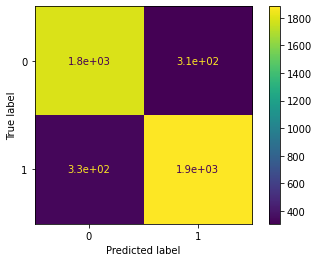

In [24]:
svc = LinearSVC(C=10.0, max_iter=50000, fit_intercept=True, random_state=42)
svc.fit(X_train_extra_stacked, y_train_extra)

full_stacked_pred = svc.predict(X_valid_extra_stacked)
print(classification_report(y_valid_extra, full_stacked_pred, target_names=['0','1']))
print(f'accuracy={accuracy_score(y_valid_extra, full_stacked_pred)}')
plot_confusion_matrix(svc, X_valid_extra_stacked, y_valid_extra)
plt.show()

With dimensionality reduction

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2102
           1       0.90      0.90      0.90      2218

    accuracy                           0.90      4320
   macro avg       0.90      0.90      0.90      4320
weighted avg       0.90      0.90      0.90      4320

accuracy=0.9009259259259259


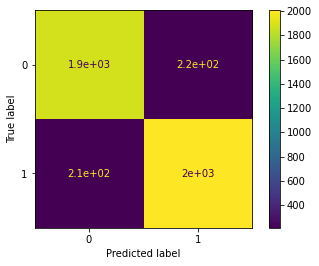

In [36]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, n_iter=25, random_state=42)
X_train_reduced = svd.fit_transform(X_train_extra_stacked)
X_valid_reduced = svd.transform(X_valid_extra_stacked)

svc = LinearSVC(C=100.0, max_iter=100000, fit_intercept=True, random_state=42)
svc.fit(X_train_reduced, y_train_extra)

full_stacked_trun_pred = svc.predict(X_valid_reduced)
print(classification_report(y_valid_extra, full_stacked_trun_pred, target_names=['0','1']))
print(f'accuracy={accuracy_score(y_valid_extra, full_stacked_trun_pred)}')
plot_confusion_matrix(svc, X_valid_reduced, y_valid_extra)
plt.show()

### Fine-tuning

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
  ('vectorizer', TfidfVectorizer(sublinear_tf=True)),
  ('svc', LinearSVC(random_state=42)),
])

param_grid = {
  'svc__C': [1.0, 10.0, 100.0],
  'vectorizer__ngram_range': [(1,6), (1,10)]
}

search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=2)
search.fit(prep_train['text'], prep_train['class'])

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [23]:
from sklearn.metrics import accuracy_score

y_pred = search.best_estimator_.predict(prep_valid['text'].values)
accuracy_score(prep_valid['class'].values, y_pred)

0.9014814814814814

## Test set prediction

In [24]:
test = pd.read_csv(test_path, header=0)
prep_test = preprocess(test)

In [19]:
from joblib import dump, load
from sklearn.metrics import accuracy_score
# dump(pipe, 'drive/My Drive/hiip/pipeline/tf_svm.joblib') 
pipe = load('drive/My Drive/hiip/pipeline/tf_svm.joblib')

0.8907407407407407

In [26]:
y_pred = search.best_estimator_.predict(prep_test['text'])
test['class'] = y_pred
submission = test[['id','class']]
submission.head()

,id,class
0,3afca6c4,0
1,a52dd7db,1
2,a95ec3a0,1
3,68c1c84a,1
4,627bbd02,1


In [27]:
submission['class'].value_counts()

1    1632
0    1368
Name: class, dtype: int64

In [34]:
submission.to_csv(f'{data_path}/submission.csv', index=False)
submission.to_csv('submission.csv', index=False)

In [30]:
show_prediction(search.best_estimator_['svc'], list(prep_test.loc[prep_test['id'] == '3c620ebd']['text'])[0], vec=search.best_estimator_['vectorizer'])

In [130]:
y = keras.utils.to_categorical(y)

In [ ]:
search = RandomizedSearchCV(pipe_grid, param_grid, )
search.fit(full_train['text'], full_train['class'])